start!!


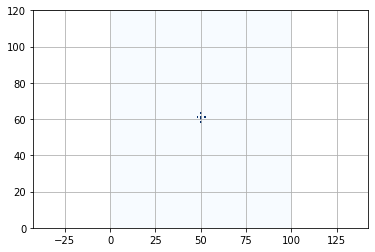

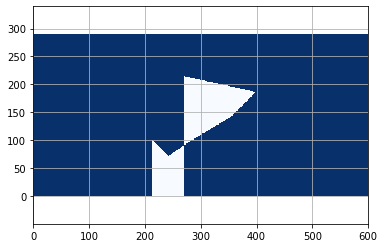

done!!


In [1]:
"""

Grid map library in python

author: Atsushi Sakai

"""
from functools import total_ordering
import matplotlib.pyplot as plt
import numpy as np


@total_ordering
class FloatGrid:

    def __init__(self, init_val=0.0):
        self.data = init_val

    def get_float_data(self):
        return self.data

    def __eq__(self, other):
        if not isinstance(other, FloatGrid):
            return NotImplemented
        return self.get_float_data() == other.get_float_data()

    def __lt__(self, other):
        if not isinstance(other, FloatGrid):
            return NotImplemented
        return self.get_float_data() < other.get_float_data()


class GridMap:
    """
    GridMap class
    """

    def __init__(self, width, height, resolution,
                 center_x, center_y, init_val=FloatGrid(0.0)):
        """__init__

        :param width: number of grid for width
        :param height: number of grid for height
        :param resolution: grid resolution [m]
        :param center_x: center x position  [m]
        :param center_y: center y position [m]
        :param init_val: initial value for all grid
        """
        self.width = width
        self.height = height
        self.resolution = resolution
        self.center_x = center_x
        self.center_y = center_y

        self.left_lower_x = self.center_x - self.width / 2.0 * self.resolution
        self.left_lower_y = self.center_y - self.height / 2.0 * self.resolution

        self.n_data = self.width * self.height
        self.data = [init_val] * self.n_data
        self.data_type = type(init_val)

    def get_value_from_xy_index(self, x_ind, y_ind):
        """get_value_from_xy_index

        when the index is out of grid map area, return None

        :param x_ind: x index
        :param y_ind: y index
        """

        grid_ind = self.calc_grid_index_from_xy_index(x_ind, y_ind)

        if 0 <= grid_ind < self.n_data:
            return self.data[grid_ind]
        else:
            return None

    def get_xy_index_from_xy_pos(self, x_pos, y_pos):
        """get_xy_index_from_xy_pos

        :param x_pos: x position [m]
        :param y_pos: y position [m]
        """
        x_ind = self.calc_xy_index_from_position(
            x_pos, self.left_lower_x, self.width)
        y_ind = self.calc_xy_index_from_position(
            y_pos, self.left_lower_y, self.height)

        return x_ind, y_ind

    def set_value_from_xy_pos(self, x_pos, y_pos, val):
        """set_value_from_xy_pos

        return bool flag, which means setting value is succeeded or not

        :param x_pos: x position [m]
        :param y_pos: y position [m]
        :param val: grid value
        """

        x_ind, y_ind = self.get_xy_index_from_xy_pos(x_pos, y_pos)

        if (not x_ind) or (not y_ind):
            return False  # NG

        flag = self.set_value_from_xy_index(x_ind, y_ind, val)

        return flag

    def set_value_from_xy_index(self, x_ind, y_ind, val):
        """set_value_from_xy_index

        return bool flag, which means setting value is succeeded or not

        :param x_ind: x index
        :param y_ind: y index
        :param val: grid value
        """

        if (x_ind is None) or (y_ind is None):
            return False, False

        grid_ind = int(y_ind * self.width + x_ind)

        if 0 <= grid_ind < self.n_data and isinstance(val, self.data_type):
            self.data[grid_ind] = val
            return True  # OK
        else:
            return False  # NG

    def set_value_from_polygon(self, pol_x, pol_y, val, inside=True):
        """set_value_from_polygon

        Setting value inside or outside polygon

        :param pol_x: x position list for a polygon
        :param pol_y: y position list for a polygon
        :param val: grid value
        :param inside: setting data inside or outside
        """

        # making ring polygon
        if (pol_x[0] != pol_x[-1]) or (pol_y[0] != pol_y[-1]):
            np.append(pol_x, pol_x[0])
            np.append(pol_y, pol_y[0])

        # setting value for all grid
        for x_ind in range(self.width):
            for y_ind in range(self.height):
                x_pos, y_pos = self.calc_grid_central_xy_position_from_xy_index(
                    x_ind, y_ind)

                flag = self.check_inside_polygon(x_pos, y_pos, pol_x, pol_y)

                if flag is inside:
                    self.set_value_from_xy_index(x_ind, y_ind, val)

    def calc_grid_index_from_xy_index(self, x_ind, y_ind):
        grid_ind = int(y_ind * self.width + x_ind)
        return grid_ind

    def calc_xy_index_from_grid_index(self, grid_ind):
        y_ind, x_ind = divmod(grid_ind, self.width)
        return x_ind, y_ind

    def calc_grid_index_from_xy_pos(self, x_pos, y_pos):
        """get_xy_index_from_xy_pos

        :param x_pos: x position [m]
        :param y_pos: y position [m]
        """
        x_ind = self.calc_xy_index_from_position(
            x_pos, self.left_lower_x, self.width)
        y_ind = self.calc_xy_index_from_position(
            y_pos, self.left_lower_y, self.height)

        return self.calc_grid_index_from_xy_index(x_ind, y_ind)

    def calc_grid_central_xy_position_from_grid_index(self, grid_ind):
        x_ind, y_ind = self.calc_xy_index_from_grid_index(grid_ind)
        return self.calc_grid_central_xy_position_from_xy_index(x_ind, y_ind)

    def calc_grid_central_xy_position_from_xy_index(self, x_ind, y_ind):
        x_pos = self.calc_grid_central_xy_position_from_index(
            x_ind, self.left_lower_x)
        y_pos = self.calc_grid_central_xy_position_from_index(
            y_ind, self.left_lower_y)

        return x_pos, y_pos

    def calc_grid_central_xy_position_from_index(self, index, lower_pos):
        return lower_pos + index * self.resolution + self.resolution / 2.0

    def calc_xy_index_from_position(self, pos, lower_pos, max_index):
        ind = int(np.floor((pos - lower_pos) / self.resolution))
        if 0 <= ind <= max_index:
            return ind
        else:
            return None

    def check_occupied_from_xy_index(self, x_ind, y_ind, occupied_val):

        val = self.get_value_from_xy_index(x_ind, y_ind)

        if val is None or val >= occupied_val:
            return True
        else:
            return False

    def expand_grid(self, occupied_val=FloatGrid(1.0)):
        x_inds, y_inds, values = [], [], []

        for ix in range(self.width):
            for iy in range(self.height):
                if self.check_occupied_from_xy_index(ix, iy, occupied_val):
                    x_inds.append(ix)
                    y_inds.append(iy)
                    values.append(self.get_value_from_xy_index(ix, iy))

        for (ix, iy, value) in zip(x_inds, y_inds, values):
            self.set_value_from_xy_index(ix + 1, iy, val=value)
            self.set_value_from_xy_index(ix, iy + 1, val=value)
            self.set_value_from_xy_index(ix + 1, iy + 1, val=value)
            self.set_value_from_xy_index(ix - 1, iy, val=value)
            self.set_value_from_xy_index(ix, iy - 1, val=value)
            self.set_value_from_xy_index(ix - 1, iy - 1, val=value)

    @staticmethod
    def check_inside_polygon(iox, ioy, x, y):

        n_point = len(x) - 1
        inside = False
        for i1 in range(n_point):
            i2 = (i1 + 1) % (n_point + 1)

            if x[i1] >= x[i2]:
                min_x, max_x = x[i2], x[i1]
            else:
                min_x, max_x = x[i1], x[i2]
            if not min_x <= iox < max_x:
                continue

            tmp1 = (y[i2] - y[i1]) / (x[i2] - x[i1])
            if (y[i1] + tmp1 * (iox - x[i1]) - ioy) > 0.0:
                inside = not inside

        return inside

    def print_grid_map_info(self):
        print("width:", self.width)
        print("height:", self.height)
        print("resolution:", self.resolution)
        print("center_x:", self.center_x)
        print("center_y:", self.center_y)
        print("left_lower_x:", self.left_lower_x)
        print("left_lower_y:", self.left_lower_y)
        print("n_data:", self.n_data)

    def plot_grid_map(self, ax=None):
        float_data_array = np.array([d.get_float_data() for d in self.data])
        grid_data = np.reshape(float_data_array, (self.height, self.width))
        if not ax:
            fig, ax = plt.subplots()
        heat_map = ax.pcolor(grid_data, cmap="Blues", vmin=0.0, vmax=1.0)
        plt.axis("equal")

        return heat_map


def polygon_set_demo():
    ox = [0.0, 4.35, 20.0, 50.0, 100.0, 130.0, 40.0]
    oy = [0.0, -4.15, -20.0, 0.0, 30.0, 60.0, 80.0]

    grid_map = GridMap(600, 290, 0.7, 60.0, 30.5)

    grid_map.set_value_from_polygon(ox, oy, FloatGrid(1.0), inside=False)

    grid_map.plot_grid_map()

    plt.axis("equal")
    plt.grid(True)


def position_set_demo():
    grid_map = GridMap(100, 120, 0.5, 10.0, -0.5)

    grid_map.set_value_from_xy_pos(10.1, -1.1, FloatGrid(1.0))
    grid_map.set_value_from_xy_pos(10.1, -0.1, FloatGrid(1.0))
    grid_map.set_value_from_xy_pos(10.1, 1.1, FloatGrid(1.0))
    grid_map.set_value_from_xy_pos(11.1, 0.1, FloatGrid(1.0))
    grid_map.set_value_from_xy_pos(10.1, 0.1, FloatGrid(1.0))
    grid_map.set_value_from_xy_pos(9.1, 0.1, FloatGrid(1.0))

    grid_map.plot_grid_map()

    plt.axis("equal")
    plt.grid(True)


def main():
    print("start!!")

    position_set_demo()
    polygon_set_demo()

    plt.show()

    print("done!!")


if __name__ == '__main__':
    main()


In [3]:
# -*- coding:utf-8 -*-
import math
import numpy as np


'''Stores attributes of map

Variables:
    min_x, min_y, max_x, max_y: border coordinates of the map in original units
    og_width, og_height: width/height of the map in orginal units
    width, height: width/height of the map in unit robot length
    robot_len: length of robot
    Following x,y are all in unit robot length
    vis[(x,y)]: visited times block (x,y)
    blocked[(x,y)]: is 1 if (x,y) is blocked, 0 otherwise
    graph[(x,y,i)]: is 1 if there is an edge from (x,y) in i direction, that is
                    an edge from (x,y) to (x+dir[i][0], y+dir[i][1])
    block_num: # blocks to be visited in the whole graph
    recorder: temporary stores the number of blocks already visited
'''
class Map():
    def __init__(self):
        self.min_x = -1
        self.min_y = -1
        self.max_x = -1
        self.max_y = -1
        self.og_width = -1
        self.og_height = -1
        self.width = -1
        self.height = -1
        self.robot_len = 0.3

        self.vis = {}
        self.blocked = {}
        self.graph = {}

        self.block_num = 0
        # TODO: recorder now stores the number of block visited 
        # because depth() isn't working at this moment, 
        # should change back to depth() once it's fixed
        self.recorder = 1
    
    # shows a graph of borders(blocked) and spanning tree(vis)
    def show(self):
        import matplotlib.pyplot as plt
        blockedx = []
        blockedy = []
        for i in range(0, self.width+1):
            for j in range(0, self.height+1):
                if (self.blocked[(i,j)]):
                    # print (i,j)
                    blockedx.append(i * self.robot_len + self.min_x)
                    blockedy.append(j * self.robot_len + self.min_y)
        plt.plot(blockedx, blockedy, '.')

        visx = []
        visy = []
        for i in range(0, self.width+1):
            for j in range(0, self.height+1):
                if (self.vis[(i,j)]):
                    visx.append(i * self.robot_len + self.min_x)
                    visy.append(j * self.robot_len + self.min_y)
        plt.plot(visx, visy, '*')

        plt.show()


    # initialize most attributes in Map, including map.height, width, vis, blocked
    # @params [filename] is the .smap file we are reading in
    def initialize_map(self, filename):
        from MapReader import MapReader
        
        import sys
        import os

        map_reader = MapReader(filename)
        map_reader.run()

        map_x = map_reader.map_x
        map_y = map_reader.map_y

        self.min_x = math.floor(min(map_reader.map_x))
        self.max_x = math.ceil(max(map_reader.map_x))
        self.og_width = self.max_x - self.min_x
        self.min_y = math.floor(min(map_reader.map_y))
        self.max_y = math.ceil(max(map_reader.map_y))
        self.og_height = self.max_y - self.min_y

        self.width = math.floor(self.og_width / self.robot_len)
        self.height = math.floor(self.og_height / self.robot_len)

        # initialize all the blocks in range
        for i in range(1,self.width+1):
            for j in range(1,self.height+1):
                self.vis[(i,j)] = 0
                self.blocked[(i,j)] = 0

        # mark all blocks with obstacles as blocked
        for i in range(len(map_reader.map_x)):
            self.blocked[self.to_point_coor(map_reader.map_x[i], map_reader.map_y[i])] = 1

        # initializethe borders to avoid array out of bound 
        for i in range(-10,self.width+10):
            for j in range(-10, self.height+10):
                if(self.is_valid_point(i,j)):
                    self.vis[(i,j)] = 0
                    self.blocked[(i,j)] = 0
                else :
                    self.vis[(i,j)] = 0
                    self.blocked[(i,j)] = 1
        
        # and count valid block numbers
        for i in range(0,self.width+2, 2):
            for j in range(0, self.height+2, 2):
                if(self.is_valid_block(i,j)):
                    self.block_num = self.block_num + 1

        # Only for small graph testing purposes:
        # Find an empty point where we can start generating spanning tree
        # start_x = -1
        # start_y = -1
        # initialized = False
        # for i in range(1,self.width+1):
        #     if initialized:
        #         break
        #     for j in range(1,self.height+1):
        #         (block_x, block_y) = point_to_block(i,j)
        #         #if not (self.vis[(i,j)] or self.blocked[(i,j)] or initialized):
        #         if self.is_valid_block(block_x, block_y) and not initialized:
        #             start_x = i
        #             start_y = j
        #             print(start_x,start_y)
        #             initialized = True
        #             break


    '''converts coordinates in map unit to our robot_length unit

    First moves the whole graph to the origin by subtracting them with min_x, min_y
    then normalizes these point into robot_length unit so that they can be 
    represented with integer index
    '''
    def to_point_coor(self, mapx, mapy):
        return ( 
            math.floor((mapx-self.min_x)/self.robot_len), 
            math.floor((mapy-self.min_y)/self.robot_len))


    # @return true when position (x,y) is within bound of the map and is not blocked
    def is_valid_point(self, x, y):
        if (x,y) in self.blocked:
            return (not self.blocked[(x,y)]) \
                and x>0 and x<self.width \
                and y>0 and y<self.height
        else :
            return False

    # @return true if all four points in this block are valid
    def is_valid_block(self, x, y):
        return x % 2 == 0 and y % 2 == 0 and \
            self.is_valid_point(x-1,y-1) and \
            self.is_valid_point(x-1,y) and \
            self.is_valid_point(x,y-1) and \
            self.is_valid_point(x,y)

'''A block class representing big blocks, containing 4 points

Each block is a node in this quadtree map, a unit of later generated 
spanning tree. Each node contains its own coordinate, the parent of this node, 
and four children of this block, in a direction of E S W N

A block always has an even number index. Block (i,j) contians point 
(i-1, j-1) (i, j-1) (i-1, j) (i, j), as in self.is_valid_block(x,y).
For example, block(2,2) contains point (1,1) (1,2) (2,1) (2,2)
'''
class Block:
    def __init__(self, ix, iy):
        self.x = ix
        self.y = iy
        self.parent = None
        self.children = np.array([None, None, None, None])


'''A point class representing the unit position of a robot

Four points constitute a block. A point's length is the same as the robot length.
'''
class Point:
    def __init__(self,*args):
        if len(args)==0:
            self.x = -1
            self.y = -1
        elif len(args) == 2:
            self.x = args[0]
            self.y = args[1]
        self.last = None
        self.next = None

# gets the block that point (ptx, pty) belongs to
def point_to_block(ptx, pty):
    return ((ptx+1) //2 *2, (pty+1)//2 *2)

In [5]:
from PyQt5.QtCore import QThread, pyqtSignal, pyqtSlot
import math
import queue

'''Includes all the logic functions related to generating spanning tree and robot path

'''
class PathPlanner():

    # reads in a map object and the starting position of robot in that map
    def __init__(self, m, rx, ry):
        self.map = m
        # direction in the sequence E S W N
        self.direction = [[1,0],[0,-1],[-1,0],[0,1]]
        # prints out debugging info of st(spanning tree) to console if set to True
        self.DEBUGst = False
        # prints out debugging info of draw_path to console if set to True
        self.DEBUGdp = False
        # root of the spanning tree
        self.root = Block(-1,-1)
        # starting position of the robot
        self.start = Point(-1, -1)
        self.robot_dir = 0

        (start_x, start_y) = self.map.to_point_coor(rx, ry)
        self.root = Block(
            point_to_block(start_x,start_y)[0],
            point_to_block(start_x,start_y)[1])



    # @return the number of nodes from this node
    # TODO: not working 
    def depth(self, node):
        def depth_aux(n, dpth):
            for i in range(4):
                if (n.children[i]!=None):
                    return depth_aux(n.children[i], dpth+1)
                else :
                    return dpth
        return depth_aux(node, 0)

    # generate a spanning tree from robot's position
    # IMPORTANT: it now stops generating when it backtraces to root and finds no 
    #            next possible node. Earlier it stops when all blocks are visited
    def spanning_tree(self):
        now = self.root
        self.map.vis[(now.x,now.y)] = 1
        while (True):
            if (self.DEBUGst):
                print("now at (%d, %d) %d" %(now.x, now.y, self.map.vis[(now.x,now.y)]))
            if (self.DEBUGst):
                print("current depth is %d" %(depth(self.root)))
                print("what is this then %d" %(self.map.recorder))

            # stop generating if all nodes are found
            # if (self.map.recorder == self.map.block_num): 
            #     print("all nodes found")
            #     break

            # looking for blocks that have not been visited
            found = False
            for i in range(4):
                nextx = now.x + self.direction[i][0] * 2
                nexty = now.y + self.direction[i][1] * 2
                if (self.DEBUGst):
                    print("next is (%d, %d)" %(nextx, nexty))
                if (self.map.is_valid_block(nextx,nexty) and 
                    self.map.vis[(nextx,nexty)]<1):
                    next = Block(nextx, nexty)
                    self.map.vis[(nextx,nexty)] = self.map.vis[(nextx,nexty)] + 1
                    next.parent = now
                    now.children[i] = next
                    now = next
                    found = True
                    self.map.recorder = self.map.recorder + 1
                    break
            
            # if we cannot find a node that hasn't been visited from current node,
            # we should start tracing back to the first node satisfying condition
            if (not found): 
                if self.DEBUGst:
                    print ("tracing back")
                new_found = False

                while (True):
                    now = now.parent
                    # Edited: Rather than meaning no solution, it means path  
                    #         generating has finished 
                    if (now == None):
                        return
                        # raise Exception("no solution")
                    for i in range(4):
                        nextx = now.x + self.direction[i][0] * 2
                        nexty = now.y + self.direction[i][1] * 2
                        if (self.DEBUGst):
                            print("next is (%d, %d) %d " %(nextx, nexty,self.map.vis[(nextx,nexty)]))
                        if (self.map.is_valid_block(nextx,nexty) and 
                            self.map.vis[(nextx,nexty)]<1):

                            next = Block(nextx, nexty)
                            self.map.vis[(nextx,nexty)] = self.map.vis[(nextx,nexty)] + 1
                            next.parent = now
                            now.children[i] = next
                            now = next
                            new_found = True
                            self.map.recorder = self.map.recorder + 1
                            break
                    if new_found:
                        break

    # print out the quadtree starting from [node] to console
    # This function isn't always working as it requires many layers of recursion
    def show_sp(self, node):
        print("now at (" + str(node.x) + ", " + str(node.y) +") ")
        has_children = False
        for i in range(4):
            if(node.children[i] != None):
                has_children = True
                print(
                    "(" + str(node.x) + ", " + str(node.y) +") ->" \
                    + "(" + str(node.children[i].x) + ", " \
                    + str(node.children[i].y) +")")
                show_sp(node.children[i])
        if not has_children:
            print("(" + str(node.x) + ", " + str(node.y) +") ->" + "None")

    # robot in point [now] facing [dr] moves direct to the next position
    def move_direct(self, now, dr):
        if (self.DEBUGdp):
            print("trying to move direct ...")
        next =  Point();
        if (dr == 1 or dr == 3) :
            next.x = now.x;
            next.y = now.y + (-2 if dr == 1 else 2)
        elif ( dr == 0 or dr == 2):
            next.y = now.y;
            next.x = now.x + (2 if dr == 0 else -2)
        else:
            raise Exception ("dr is not in the range [0,3]")

        next.last = now;
        now.next = next;

        if (self.DEBUGdp):
            print("(%d, %d)" %(next.x, next.y))
        return next;

    # robot in point [now] facing [dr] turns right and moves to the next position
    def turn_right(self, now, dr):
        if (self.DEBUGdp):
            print("trying to turn right...")
        toturn = Point()
        turned = Point()

        if dr == 0: 
            toturn.x = now.x + 1
            toturn.y = now.y
            turned.x = toturn.x
            turned.y = toturn.y - 2
        elif dr == 1:
            toturn.x = now.x
            toturn.y = now.y - 1
            turned.x = toturn.x - 2
            turned.y = toturn.y
        elif dr == 2:
            toturn.x = now.x - 1
            toturn.y = now.y
            turned.x = toturn.x
            turned.y = toturn.y + 2
        elif dr == 3:
            toturn.x = now.x
            toturn.y = now.y + 1
            turned.x = toturn.x + 2
            turned.y = toturn.y
        else:
            raise Exception ("dr is not in the range [0,3]")

        toturn.last = now
        now.next = toturn
        turned.last = toturn
        toturn.next = turned
        if (self.DEBUGdp):
            print("(%d, %d)" %(toturn.x, toturn.y))
            print("(%d, %d)" %(turned.x, turned.y))
        return turned

    # robot in point [now] facing [dr] turns left and moves to the next position
    def turn_left(self, now, dr):
        if (self.DEBUGdp):
            print("trying to turn left...")
        next = Point()
        if (dr == 1 or dr == 3):
            next.x = now.x + (1 if dr==1 else -1)
            next.y = now.y
        elif (dr == 0 or dr == 2):
            next.x = now.x
            next.y = now.y + (1 if dr==0 else -1)
        else:
            raise Exception ("dr is not in the range [0,3]")
        next.last = now
        now.next = next
        if (self.DEBUGdp):
            print("(%d, %d)" %(next.x, next.y))
        return next

    # robot in point [now] facing [dr] makes a turn and moves to the next position
    def turn_around(self, now, dr):
        if (self.DEBUGdp):
            print("trying to turn around...")
        turn1 = Point()
        turn2 = Point()
        turned = Point()
        if dr == 0:
            turn1.x = now.x + 1
            turn1.y = now.y
            turn2.x = turn1.x
            turn2.y = turn1.y - 1
            turned.x = turn2.x - 2
            turned.y = turn2.y
        elif dr == 1:
            turn1.x = now.x
            turn1.y = now.y - 1
            turn2.x = turn1.x - 1
            turn2.y = turn1.y
            turned.x = turn2.x
            turned.y = turn2.y + 2
        elif dr == 2:
            turn1.x = now.x - 1
            turn1.y = now.y
            turn2.x = turn1.x
            turn2.y = turn1.y + 1
            turned.x = turn2.x + 2
            turned.y = turn2.y
        elif dr == 3:
            turn1.x = now.x
            turn1.y = now.y + 1
            turn2.x = turn1.x + 1
            turn2.y = turn1.y
            turned.x = turn2.x
            turned.y = turn2.y - 2
        else:
            raise Exception ("dr is not in the range [0,3]")

        turn1.last = now
        now.next = turn1
        turn2.last = turn1
        turn1.next = turn2
        turned.last = turn2
        turn2.next = turned
        if (self.DEBUGdp):
            print("(%d, %d)" %(turn1.x, turn1.y))
            print("(%d, %d)" %(turn2.x, turn2.y))
            print("(%d, %d)" %(turned.x, turned.y))

        return turned

    # @return initialized robot position as a point object 
    #         and initialized robot direction
    # initialize the robot's position according to the first edge from root node
    # the initialized position also follows robot position rule specifed in the
    # head comment(not surpassing edge end node, wall always on robot's right side)
    def initialize_position(self):

        if self.map.graph[(self.root.x, self.root.y, 0)]:
            return (Point(self.root.x+1, self.root.y), 0)
        elif self.map.graph[(self.root.x, self.root.y, 1)]:
            return (Point(self.root.x, self.root.y-1), 1)
        elif self.map.graph[(self.root.x, self.root.y, 2)]:
            return (Point(self.root.x-2, self.root.y), 2)
        elif self.map.graph[(self.root.x, self.root.y, 3)]:
            return (Point(self.root.x-1, self.root.y+1), 3)
        else :
            raise Exception ("No edge from toot, Graph not initialized")

    # initialize self.map.graph, robot position, and robot direction
    # used a queue to avoid exceeding maximu recursion level
    def initialize_graph(self):
        for i in range(0, self.map.width+2):
            for j in range(0, self.map.height+2):
                for k in range(4):
                    self.map.graph[(i, j, k)] = 0
        q = queue.Queue()
        def initialize_graph_aux(now):
            for i in range(4):
                next = now.children[i]
                if (next!=None) :
                    self.map.graph[(now.x, now.y, i)] = 1
                    self.map.graph[(next.x, next.y, (i+2)%4)] = 1
                    q.put(next)
        initialize_graph_aux(self.root)
        while not q.empty() :
            initialize_graph_aux(q.get())

        (self.start, self.robot_dir) = self.initialize_position()

    '''Draws the robot's path around generated spanning tree

    draw_path() first initializes a graph of wall(spanning tree), along which the
    robot runs, and the robot's initial position.
    It then starts to draw path. Recall the wall is always on the robot's right side.
        1. When we encounter a wall ahead of us, we turn left.
        2. When the wall extends along with direction unchanged, 
        we follow this wall and go direct.
        3. When the wall turns right, the robot turns right too.
        4. When none of the above condition is satisfied, 
        we reached the end of an edge and should turn around to the other side.
    It repeats the above 4 actions until it completes a round trip along the wall, 
    that's when it reaches back to the initial position.
    '''
    def draw_path(self):
        self.initialize_graph()
        now = self.start
        

        if self.DEBUGdp:
            print("now at (%d, %d)" %(now.x, now.y))

        do = True
        while (now.x != self.start.x or now.y != self.start.y) or do:
            do = False
            if self.DEBUGdp:
                print("now at (%d, %d) facing %d" %(now.x, now.y, self.robot_dir))
            (block_x, block_y) = point_to_block(now.x, now.y)
            # block_x = get_block_coor(now.x)
            # block_y = get_block_coor(now.y)

            #TODO: comment 
            if self.map.graph[(block_x, block_y, (self.robot_dir+3)%4)]: #先判定左孩子，其实是 (dir-1)%4
                now = self.turn_left(now, self.robot_dir)
                self.robot_dir = (self.robot_dir+3) % 4
            elif self.map.graph[(block_x, block_y, (self.robot_dir))]:
                now = self.move_direct(now, self.robot_dir)
            elif self.map.graph[(block_x, block_y, (self.robot_dir+1)%4)]:
                now = self.turn_right(now, self.robot_dir)
                self.robot_dir = (self.robot_dir+1) % 4
            elif self.map.graph[(block_x, block_y, (self.robot_dir+2)%4)]:
                now = self.turn_around(now, self.robot_dir)
                self.robot_dir = (self.robot_dir+2) % 4
            else :
                raise Exception ("no solution")



    
    # convert robot's path, stored in linked list, to a python list
    def get_path(self):
        result = []
        now = self.start
        do = True
        while (now.x != self.start.x or now.y != self.start.y) or do:
            do = False
            # result.append((now.x * self.map.robot_len, now.y * self.map.robot_len))
            result.append((now.x, now.y))
            now = now.next
        return result

In [6]:
# Map Reader copied from [MapWidget.py]
import json as js
class MapReader():
    def __init__(self, filename):
        self.map_name = filename
        self.js = dict()
        self.map_x = []
        self.map_y = []
        self.verts = []
        self.circles = []
        self.points = []
        self.straights = []
        self.res = -1
    # run method gets called when we start the thread
    def run(self):
        fid = open(self.map_name, encoding= 'UTF-8')
        self.js = js.load(fid)
        fid.close()
        self.map_x = []
        self.map_y = []
        self.verts = []
        self.circles = []
        self.straights = []
        self.points = []
        self.p_names = []
        self.res = self.js['header']['resolution']
        # print(self.js.keys())
        for pos in self.js['normalPosList']:
            if 'x' in pos:
                self.map_x.append(float(pos['x']))
            else:
                self.map_x.append(0.0)
            if 'y' in pos:
                self.map_y.append(float(pos['y']))
            else:
                self.map_y.append(0.0)
        if 'advancedCurveList' in self.js:
            for line in self.js['advancedCurveList']:
                if line['className'] == 'BezierPath':
                    x0 = 0
                    y0 = 0
                    x1 = 0
                    y1 = 0
                    x2 = 0
                    y2 = 0
                    x3 = 0
                    y3 = 0
                    if 'x' in line['startPos']['pos']:
                        x0 = line['startPos']['pos']['x']
                    if 'y' in line['startPos']['pos']:
                        y0 = line['startPos']['pos']['y']
                    if 'x' in line['controlPos1']:
                        x1 = line['controlPos1']['x']
                    if 'y' in line['controlPos1']:
                        y1 = line['controlPos1']['y']
                    if 'x' in line['controlPos2']:
                        x2 = line['controlPos2']['x']
                    if 'y' in line['controlPos2']:
                        y2 = line['controlPos2']['y']
                    if 'x' in line['endPos']['pos']:
                        x3 = line['endPos']['pos']['x']
                    if 'y' in line['endPos']['pos']:
                        y3 = line['endPos']['pos']['y']
                    self.verts.append([(x0,y0),(x1,y1),(x2,y2),(x3,y3)])
                elif line['className'] == 'ArcPath':
                    x1 = 0
                    y1 = 0
                    x2 = 0
                    y2 = 0
                    x3 = 0
                    y3 = 0
                    if 'x' in line['startPos']['pos']:
                        x1 = line['startPos']['pos']['x']
                    if 'y' in line['startPos']['pos']:
                        y1 = line['startPos']['pos']['y']
                    if 'x' in line['controlPos1']:
                        x2 = line['controlPos1']['x']
                    if 'y' in line['controlPos1']:
                        y2 = line['controlPos1']['y']
                    if 'x' in line['endPos']['pos']:
                        x3 = line['endPos']['pos']['x']
                    if 'y' in line['endPos']['pos']:
                        y3 = line['endPos']['pos']['y']
                    A = x1*(y2-y3) - y1*(x2-x3)+x2*y3-x3*y2
                    B = (x1*x1 + y1*y1)*(y3-y2)+(x2*x2+y2*y2)*(y1-y3)+(x3*x3+y3*y3)*(y2-y1)
                    C = (x1*x1 + y1*y1)*(x2-x3)+(x2*x2+y2*y2)*(x3-x1)+(x3*x3+y3*y3)*(x1-x2)
                    D = (x1*x1 + y1*y1)*(x3*y2-x2*y3)+(x2*x2+y2*y2)*(x1*y3-x3*y1)+(x3*x3+y3*y3)*(x2*y1-x1*y2)
                    if abs(A) > 1e-12:
                        x = -B/2/A
                        y = -C/2/A
                        r = math.sqrt((B*B+C*C-4*A*D)/(4*A*A))
                        theta1 = math.atan2(y1-y,x1-x)
                        theta3 = math.atan2(y3-y,x3-x)
                        v1 = np.array([x2-x1,y2-y1])
                        v2 = np.array([x3-x2,y3-y2])
                        flag = float(np.cross(v1,v2))
                        if flag >= 0:
                            self.circles.append([x, y, r, np.rad2deg(theta1), np.rad2deg(theta3)])
                        else:
                            self.circles.append([x, y, r, np.rad2deg(theta3), np.rad2deg(theta1)])
                    else:
                        self.straights.append([(x1,y1),(x3,y3)])
                elif line['className'] == 'StraightPath':
                    x1 = 0
                    y1 = 0
                    x2 = 0
                    y2 = 0
                    if 'x' in line['startPos']['pos']:
                        x1 = line['startPos']['pos']['x']
                    if 'y' in line['startPos']['pos']:
                        y1 = line['startPos']['pos']['y']
                    if 'x' in line['endPos']['pos']:
                        x2 = line['endPos']['pos']['x']
                    if 'y' in line['endPos']['pos']:
                        y2 = line['endPos']['pos']['y']
                    self.straights.append([(x1,y1),(x2,y2)])
        if 'advancedPointList' in self.js:
            for pt in self.js['advancedPointList']:
                x0 = 0
                y0 = 0 
                theta = 0
                if 'x' in pt['pos']:
                    x0 = pt['pos']['x']
                if 'y' in pt['pos']:
                    y0 = pt['pos']['y']
                if 'dir' in pt:
                    theta = pt['dir']
                if  'ignoreDir' in pt:
                    if pt['ignoreDir'] == True:
                        theta = None
                self.points.append([x0,y0,theta])
                self.p_names.append([pt['instanceName']])

In [7]:
# shows a graph of borders(blocked), spanning tree(vis), and robot's path(path)
def show_graph(map, path):
    import matplotlib.pyplot as plt
    blockedx = []
    blockedy = []
    for i in range(0, map.width+1):
        for j in range(0, map.height+1):
            if (map.blocked[(i,j)]):
                # print (i,j)
                blockedx.append(i * map.robot_len + map.min_x)
                blockedy.append(j * map.robot_len + map.min_y)
    plt.plot(blockedx, blockedy, '.')

    # visx = []
    # visy = []
    # for i in range(0, map.width+1):
    #     for j in range(0, map.height+1):
    #         if (map.vis[(i,j)]):
    #             visx.append(i * map.robot_len + map.min_x)
    #             visy.append(j * map.robot_len + map.min_y)
    # plt.plot(visx, visy, '*')
    
    pathx = []
    pathy = []
    for i in path:
        pathx.append(i[0] * map.robot_len + map.min_x)
        pathy.append(i[1] * map.robot_len + map.min_y)
    plt.plot(pathx, pathy, '.-')

    plt.show()

def main():

    # initialize a map object
    map_path = "D://Programming//Seer_Robot//My_Implementation//3_v2.smap"
    my_map = Map()
    my_map.initialize_map(map_path)
    
    # initialize a path planner by giving it map object and the coordinate of 
    # the robot in map's original unit. Then start generating spanning tree,
    # generating path, and drawing out resulted path graph
    planner = PathPlanner(my_map, 20, 10)
    planner.spanning_tree()
    # planner.show_sp(root)
    planner.draw_path()
    result = planner.get_path()
    show_graph(my_map, result)




# if __name__ == "__main__":
#     main()